In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as ss

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib
%matplotlib inline

import pymuqUtilities as mu
import pymuqModeling_ as mm

import plotutil, approximation
from TransportMap import *

/tmp/ipykernel_22118/1312280215.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


ModuleNotFoundError: No module named 'pymuqUtilities'

In [2]:
def invert(f, y, low=-1, high=1) :
    midpoint = lambda interval : interval[0] + (interval[1] - interval[0])/2

    interval = [low, high]
    x = midpoint(interval)
    candidate = f(x)

    for _ in range(30) : # 2^-14 < 1e-4
        if candidate > y :
            interval = [interval[0],  x]
        else :
            interval = [x, interval[1]]
        x = midpoint(interval)
        candidate = f(x)

    return x

def f_pi(x, m, sigma) :
    return np.exp(-((x-m)/sigma)**2/2)/sigma/np.sqrt(2*np.pi)

def F_pi(x, m, sigma) :
    return (ss.erf((x-m)/(np.sqrt(2)*sigma)) + ss.erf((m + 1)/(np.sqrt(2)*sigma)))/2

def F_pi_inv(y, m, sigma) :
    return invert(lambda x : F_pi(x, m, sigma), y)

def f_mu(x) :
    return 1/2

def F_mu(x) :
    return (x + 1)/2

def F_mu_inv(y) :
    return 2*y-1

sigma_default = .1
m_default = .2
if False :
    ax1 = plotutil.get_ax(plt.figure(figsize=(25,7)), 1, 1, title='')
    x = np.linspace(-1, 1, 301)
    #ax1.plot(x, [F_pi_inv(xi, m_default, sigma_default) for xi in x])
    ax1.plot(x, [F_mu_inv(xi) for xi in x])
    plt.show()

In [3]:
class TransportMapGauss1DExact :
    
    def __init__(self, m, sigma) :
        self.m = m
        self.sigma = sigma
    
    def evaluate(self, x) :
        return F_pi_inv(F_mu(x), self.m, self.sigma)
    
    def inverse_evaluate(self, y) :
        return F_mu_inv(F_pi(y, self.m, self.sigma))
    
    def density(self, x) :
        return f_pi(x, self.m, self.sigma)

In [28]:
class T_k_hat :
    
    def __init__(self, t_k, T) :
        self.t_k = t_k
        self.T = T
        
    def evaluate(self, x) :
        return (1 - self.t_k) * np.array(x) + self.t_k * np.array(self.T.evaluate(x))
    
    def inverse_evaluate(self, y) :
        return invert(self.evaluate, y)
    
class f_tau_k(mm.PyModPiece) :
    
    def __init__(self, t_k, t_k_1, T) :
        super(f_tau_k, self).__init__([1], [1])
        self.t_k = t_k
        self.t_k_1 = t_k_1
        self.T = T
        self.T_k_1_hat = T_k_hat(t_k_1, T)
        
    def EvaluateImpl(self, inputs) :
        self.outputs = [ np.array([np.sqrt(self.density(inputs[0]))]) ]
        
    def density(self, x) :
        x = 1/T.density(T.evaluate(self.T_k_1_hat.inverse_evaluate(x)))
        return (1 - self.t_k + self.t_k * x)/(1 - self.t_k_1 + self.t_k_1 * x)

T = TransportMapGauss1DExact(m_default, sigma_default)

multiset = mu.MultiIndexFactory.CreateAnisotropic([.7], .001)
print('Number of multi-indices : ', multiset.Size())

T_k_list = []
f_tau_k_list = []
t = [0, .2, .5, .7, 1]
for k in range(len(t) - 1) :
    f_tau_k_list.append( f_tau_k(t[k], t[k+1], T))
    T_k_list.append(TransportMap(1, approximation.pce(f_tau_k_list[-1], 1, multiset, 'wls'), multiset))
    
def cdirt(x) :
    x = [x]
    for T_k in T_k_list :
        x = T_k.inverse_evaluate(x)
    return x

Number of multi-indices :  20


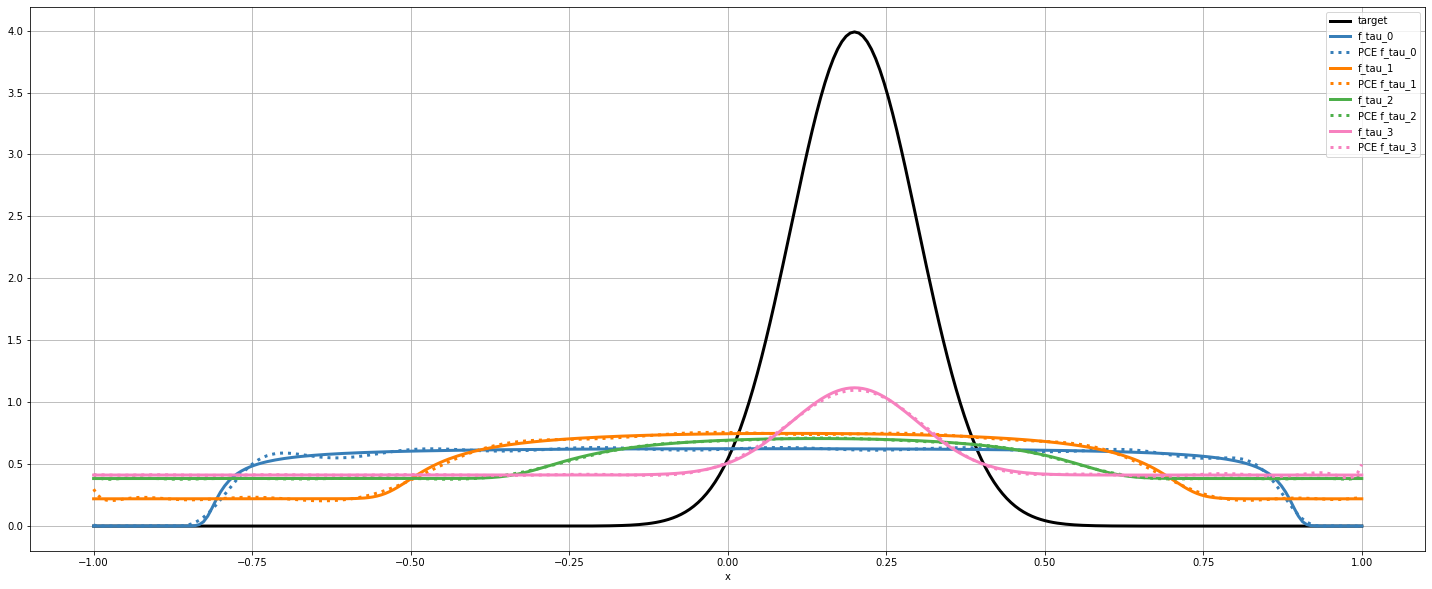

In [29]:
x = np.linspace(-1, 1, 301)

ax1 = plotutil.get_ax(plt.figure(figsize=(25,10)), 1, 1, title='')
ax1.plot(x, np.array([T.density(xi) for xi in x]), lw=3, color='k', label='target')

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
for k in range(len(T_k_list)) :
    density = [f_tau_k_list[k].density(xi) for xi in x]
    density /= np.sum(density)*2/len(x)
    ax1.plot(x, density, lw=3, color=colors[k], label='f_tau_{}'.format(k))
    
    density = [T_k_list[k].det_dS([xi]) for xi in x]
    density /= np.sum(density)*2/len(x)
    ax1.plot(x, density, lw=3, ls='dotted', color=colors[k], label='PCE f_tau_{}'.format(k))
    
density = [T.density(xi) for xi in x]
density /= np.sum(density)*2/len(x)
#ax1.plot(x, density, 'k', lw=3, ls='dotted', label='T_# mu')

ax1.legend()

plt.show()

In [30]:
samples = [cdirt(x)[0] for x in np.random.uniform(low=-1, high=1, size=(1000,))]

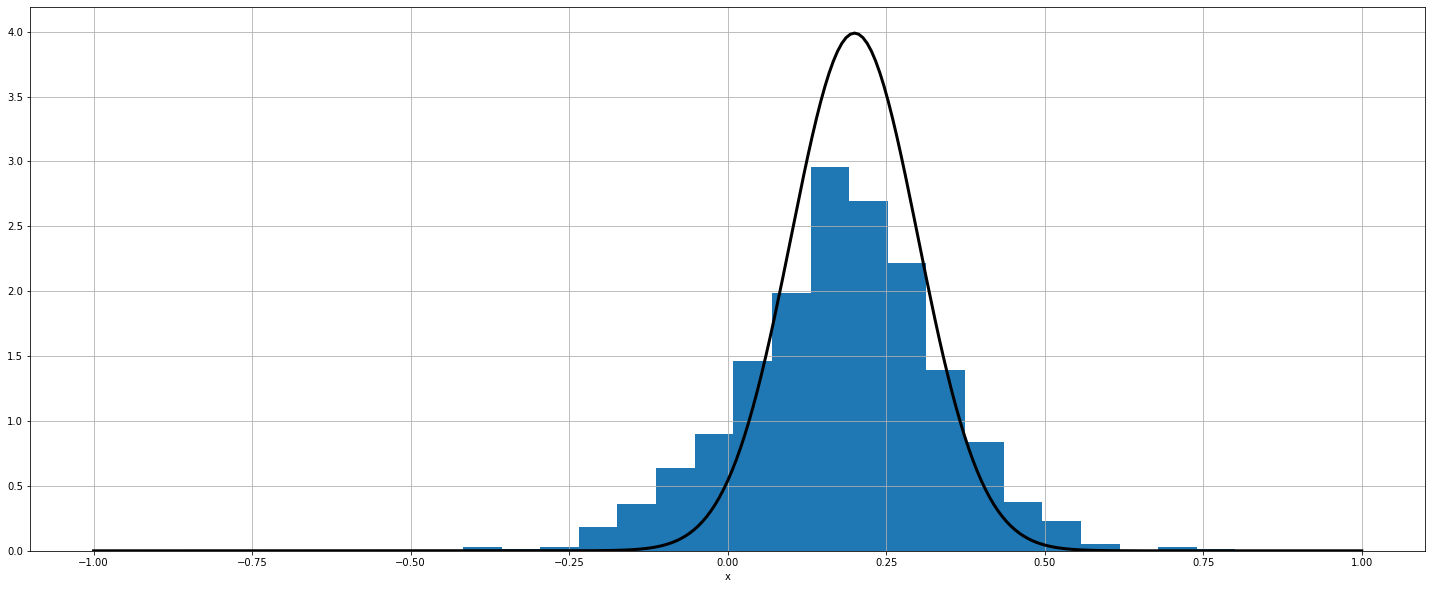

In [31]:
ax1 = plotutil.get_ax(plt.figure(figsize=(25,10)), 1, 1, title='')
hist = ax1.hist(samples, bins=20, density=True)
ax1.plot(x, true_target, lw=3, color='k', label='target')
plt.show()

## Bridging density for k=0

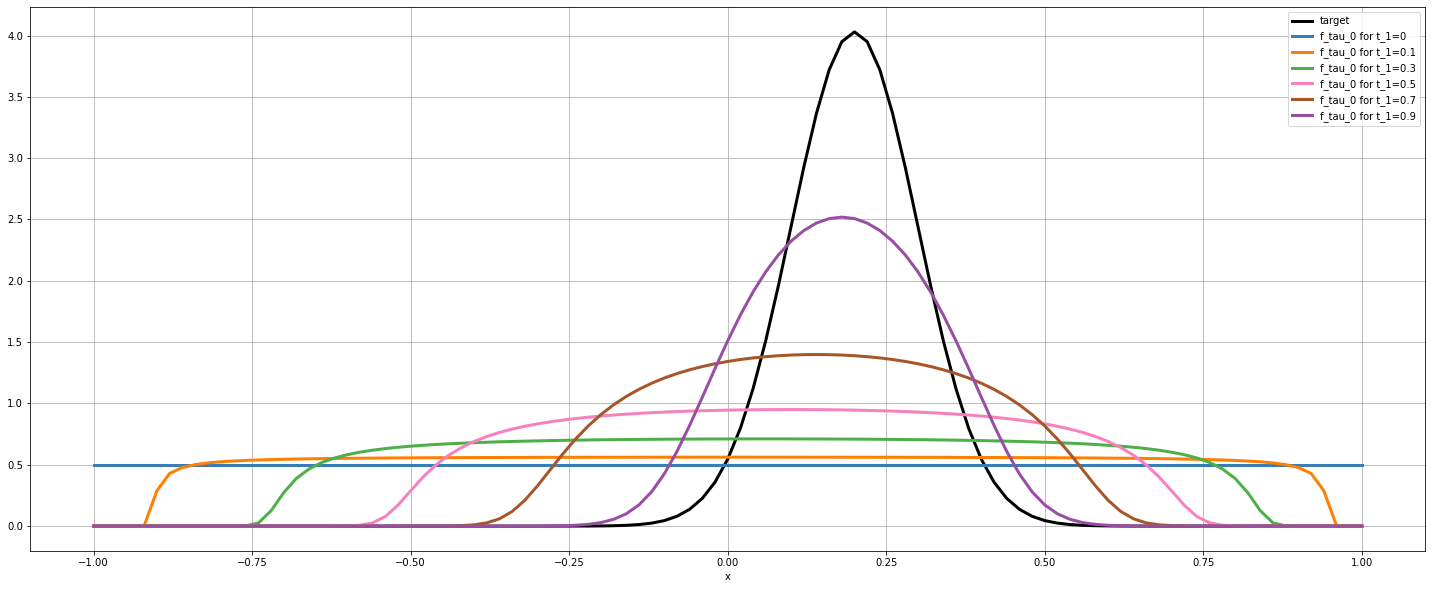

In [32]:
T = TransportMapGauss1DExact(m_default, sigma_default)

x = np.linspace(-1, 1, 101)

ax1 = plotutil.get_ax(plt.figure(figsize=(25,10)), 1, 1, title='')

true_target = np.array([T.density(xi) for xi in x])
true_target /= np.sum(true_target)*2/len(x)
ax1.plot(x, true_target, lw=3, color='k', label='target')

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
t_1 = [0, .1, .3, .5, .7, .9]
for k in range(len(t_1)) :
    target_k = f_tau_k(0, t_1[k], T)
    density = [target_k.density(xi) for xi in x]
    density /= np.sum(density)*2/len(x)
    ax1.plot(x, density, lw=3, color=colors[k], label='f_tau_0 for t_1={}'.format(t_1[k]))

ax1.legend()
#plt.savefig('dirt_example_1d.pdf', format='pdf')
plt.show()

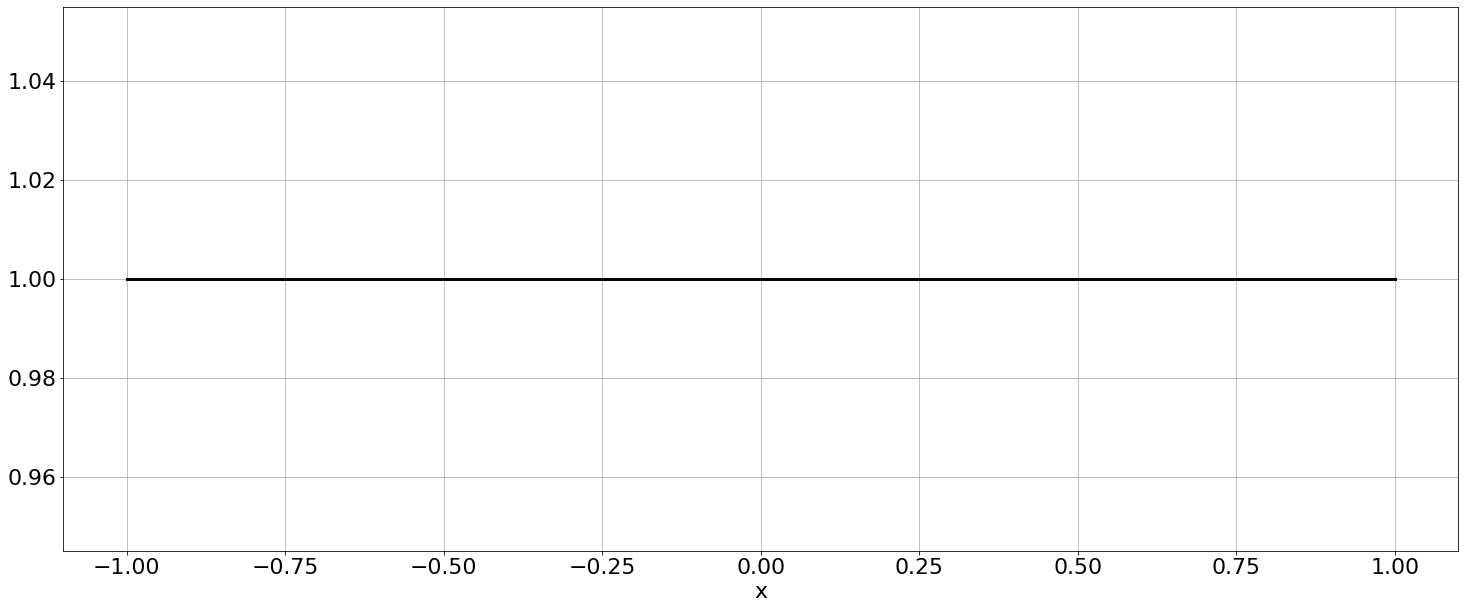

In [23]:
t = np.linspace(-1, 1, 201)
ax1 = plotutil.get_ax(plt.figure(figsize=(25,10)), 1, 1, title='')
ax1.plot(t, [1/(1-xi+xi/1) for xi in t], lw=3, color='k', label='target')

In [20]:
1/(1-0+0/.003)

1.0